In [132]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import cheby1, lfilter, freqz, sosfilt
from scipy.io import wavfile
from scipy.fftpack import fft

# Chebyshev 필터 선언

In [133]:
def cheby_bandpass_sos(lowcut, highcut, fs, order=5):
    sos = cheby1(order, 1, [lowcut, highcut], btype='band', analog=False, output='sos', fs=fs)
    return sos

In [134]:
def cheby_bandstop_sos(lowcut, highcut, fs, order=5):
    sos = cheby1(order, 1, [lowcut, highcut], btype='stop', analog=False, output='sos', fs=fs)
    return sos

In [135]:
def cheby_lowpass_sos(highcut, fs, order=5):
    sos = cheby1(order, 1, highcut, btype='low', analog=False, output='sos', fs=fs)
    return sos

In [136]:
def cheby_highpass_sos(lowcut, fs, order=5):
    sos = cheby1(order, 1, lowcut, btype='high', analog=False, output='sos', fs=fs)
    return sos

# EQ 곡선 그리는 함수 선언

In [137]:
def plot_eq_curve(freq, y_origin, y_filter, filter_type=None, lowcut=None, highcut=None):
    plt.figure(figsize=(10, 6))
    
    plt.plot(freq, y_origin, 'r', label="Original")
    
    if filter_type:
        plt.plot(freq, y_filter, 'b', label=f'Filtered {filter_type}')
        if filter_type == "LPF" and highcut:
            plt.xlim([0, 2 * highcut])
            plt.axvline(highcut, color='g', linestyle='--', label=f'Cutoff: {highcut} Hz')
        elif filter_type == "HPF" and lowcut:
            plt.xlim([0, 2 * lowcut])
            plt.axvline(lowcut, color='g', linestyle='--', label=f'Cutoff: {lowcut} Hz')
        elif filter_type in ["BPF", "BSF"] and highcut and lowcut:
            plt.xlim([0, 2 * highcut])
            plt.axvspan(lowcut, highcut, color='green', alpha=0.2, label=f'{filter_type} region: {lowcut}~{highcut} Hz')
            
    plt.title('EQ Curve')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'../media/{filter_type}.png')
    plt.show()

# 유틸 함수 선언

In [138]:
from scipy.signal import welch

def apply_filter(data, fs, filter_type=None, lowcut=None, highcut=None, order=5):
    
    if filter_type == "BPF":
        sos = cheby_bandpass_sos(lowcut, highcut, fs, order=order)
    elif filter_type == "HPF":
        sos = cheby_highpass_sos(lowcut, fs, order=order)
    elif filter_type == "LPF":
        sos = cheby_lowpass_sos(highcut, fs, order=order)
    elif filter_type == "BSF":
        sos = cheby_bandstop_sos(lowcut, highcut, fs, order=order)
    else:
        sos = None

    freq, psd_original = welch(data, fs=fs, nperseg=1024, noverlap=512)
    psd_original_db = 10 * np.log10(psd_original + 1.e-6)

    if sos is not None:
        filtered_data = sosfilt(sos, data)
        filtered_data = np.real(filtered_data)
        
        _, psd_filter = welch(filtered_data, fs=fs, nperseg=1024, noverlap=512)
        psd_filter_db = 10 * np.log10(psd_filter + 1.e-6)
        min_size = min(len(freq), len(psd_original_db), len(psd_filter_db))
        psd_filter_db = psd_filter_db[:min_size]
    else:
        psd_filter_db = None
        filtered_data = None
        min_size = min(len(freq), len(psd_original_db))
        
    psd_original_db = psd_original_db[:min_size]
        
    plot_eq_curve(
        freq=freq,
        y_origin=psd_original_db, 
        y_filter=psd_filter_db, 
        filter_type=filter_type, 
        highcut=highcut, 
        lowcut=lowcut
        )
    
    return filtered_data

# 원래 샘플 파일 EQ 곡선 출력

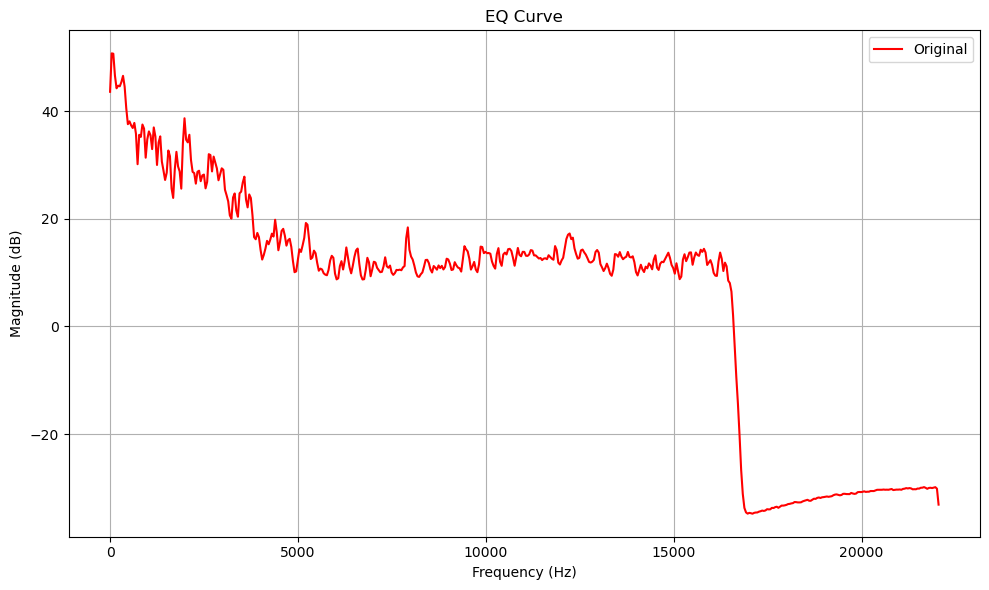

In [139]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fs, data = wavfile.read('../media/sample.wav')
apply_filter(data=data, fs=fs)

# 필터 적용한 결과 EQ 곡선 적용

In [140]:
lowcut = 500.0
highcut = 1500.0

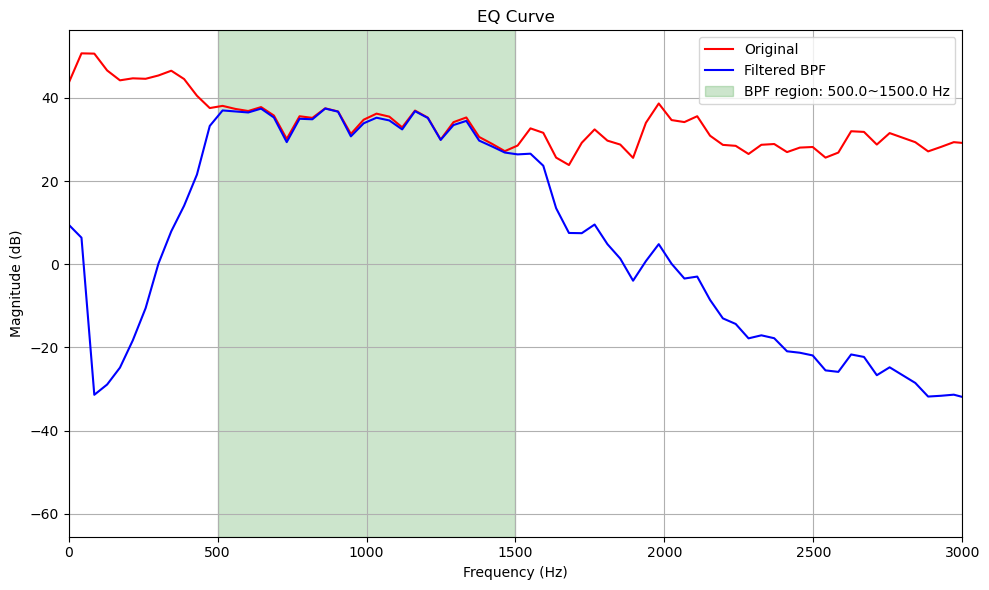

In [141]:
data_bpf = apply_filter(
    data=data, 
    fs=fs, 
    filter_type="BPF", 
    lowcut=lowcut, 
    highcut=highcut
    )

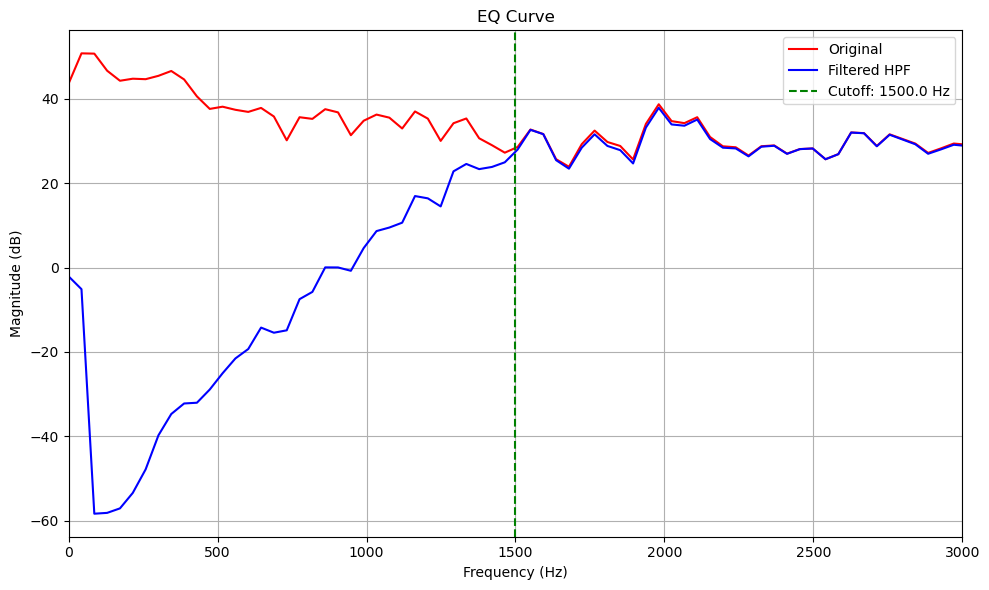

In [142]:
data_hpf = apply_filter(
    data=data, 
    fs=fs, 
    filter_type="HPF", 
    lowcut=highcut
    )

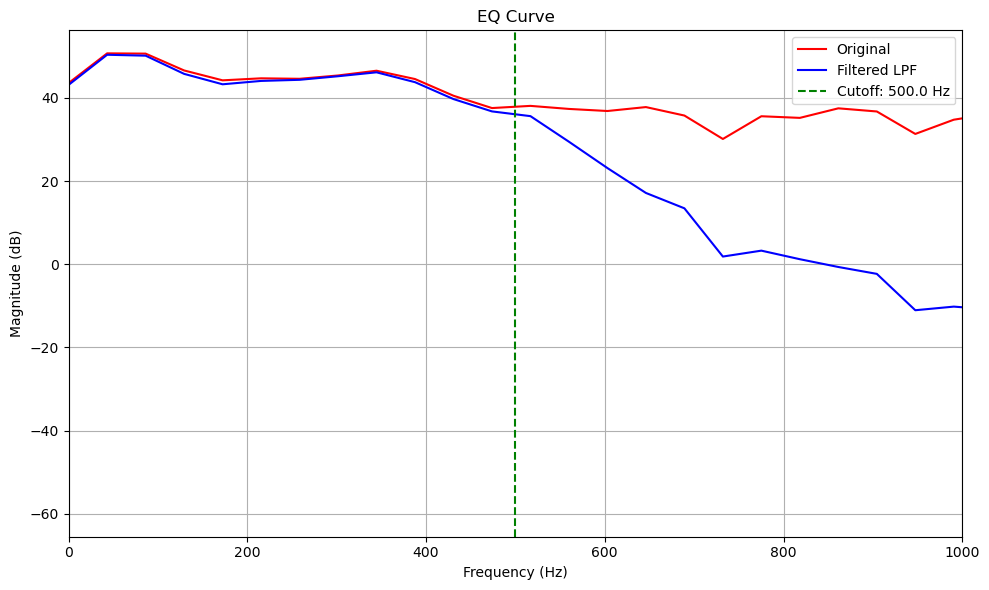

In [143]:
data_lpf = apply_filter(
    data=data, 
    fs=fs, 
    filter_type="LPF", 
    highcut=lowcut
    )

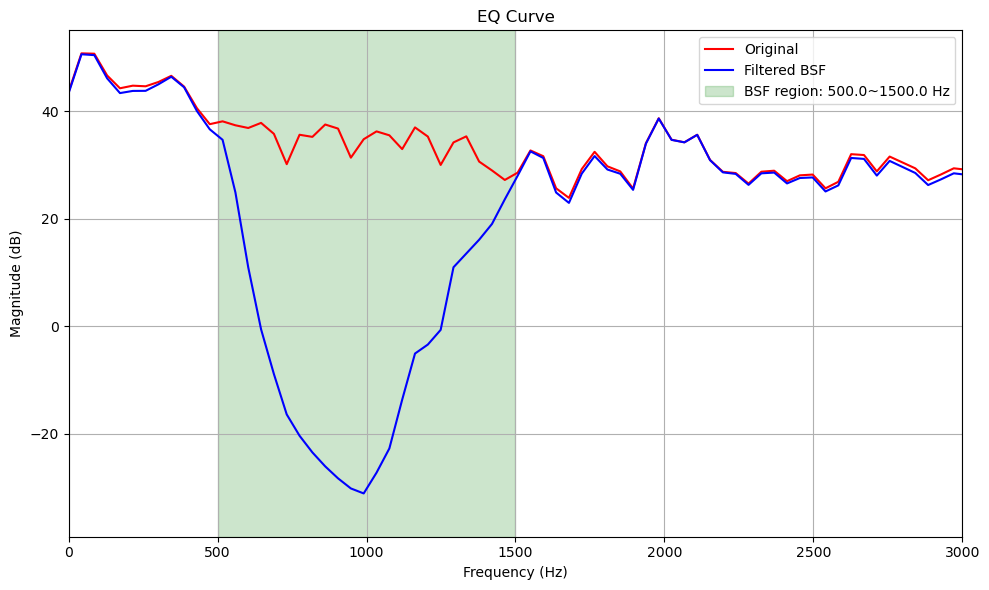

In [144]:
data_bsf = apply_filter(
    data=data, 
    fs=fs, 
    filter_type="BSF", 
    lowcut=lowcut, 
    highcut=highcut
    )

In [145]:
# Save processed data to new .wav files
wavfile.write('../media/output_bpf.wav', fs, data_bpf.astype(np.int16))
wavfile.write('../media/output_hpf.wav', fs, data_hpf.astype(np.int16))
wavfile.write('../media/output_lpf.wav', fs, data_lpf.astype(np.int16))
wavfile.write('../media/output_bsf.wav', fs, data_bsf.astype(np.int16))